## Assignment 1
## Health Analytics
## Anna Jazayeri


In [1]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import warnings
# Ignore only specific warnings (e.g., UserWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Data Augmentation and splitting the train and valid data 

In [2]:
# Define dataset path
dataset_path = "C:/Users/annaj/Desktop/Python/health/brain_tumor_dataset/"  # Path to the folder that contains the MRI images with and without tumors

# Data augmentation and preprocessing for training
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to the range [0, 1] for faster convergence
    rotation_range=20,           # Randomly rotate images by up to 20 degrees to make the model more robust
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20% of the image width
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20% of the image height
    shear_range=0.2,             # Apply shear transformations to the images to introduce more variation
    zoom_range=0.2,              # Randomly zoom into the image by up to 20%
    horizontal_flip=True,        # Randomly flip images horizontally to simulate variations in orientation
    fill_mode='nearest',         # Fill in new pixels after transformations using the nearest pixel values
    validation_split=0.2         # Reserve 20% of the data for validation (split between training and validation)
)

# No augmentation for validation set, just rescaling
valid_datagen = ImageDataGenerator(
    rescale=1./255,              # Only rescale validation images, no augmentation
    validation_split=0.2         # Use the same 20% split for validation
)

# Load training data with augmentation
train_data = train_datagen.flow_from_directory(
    dataset_path,                # Path to the dataset directory
    target_size=(150, 150),      # Resize all images to 150x150 pixels (standard input size for CNNs)
    batch_size=32,               # Load images in batches of 32 for memory efficiency
    class_mode='binary',         # Use binary classification (has tumor or not)
    subset='training'            # Specify that this is the training subset
)

# Load validation data (no augmentation)
validation_data = valid_datagen.flow_from_directory(
    dataset_path,                # Path to the dataset directory
    target_size=(150, 150),      # Resize all validation images to 150x150 pixels
    batch_size=32,               # Load validation images in batches of 32
    class_mode='binary',         # Use binary classification (has tumor or not)
    subset='validation'          # Specify that this is the validation subset
)


Found 203 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


### Showing some of the augmented photos with their labels

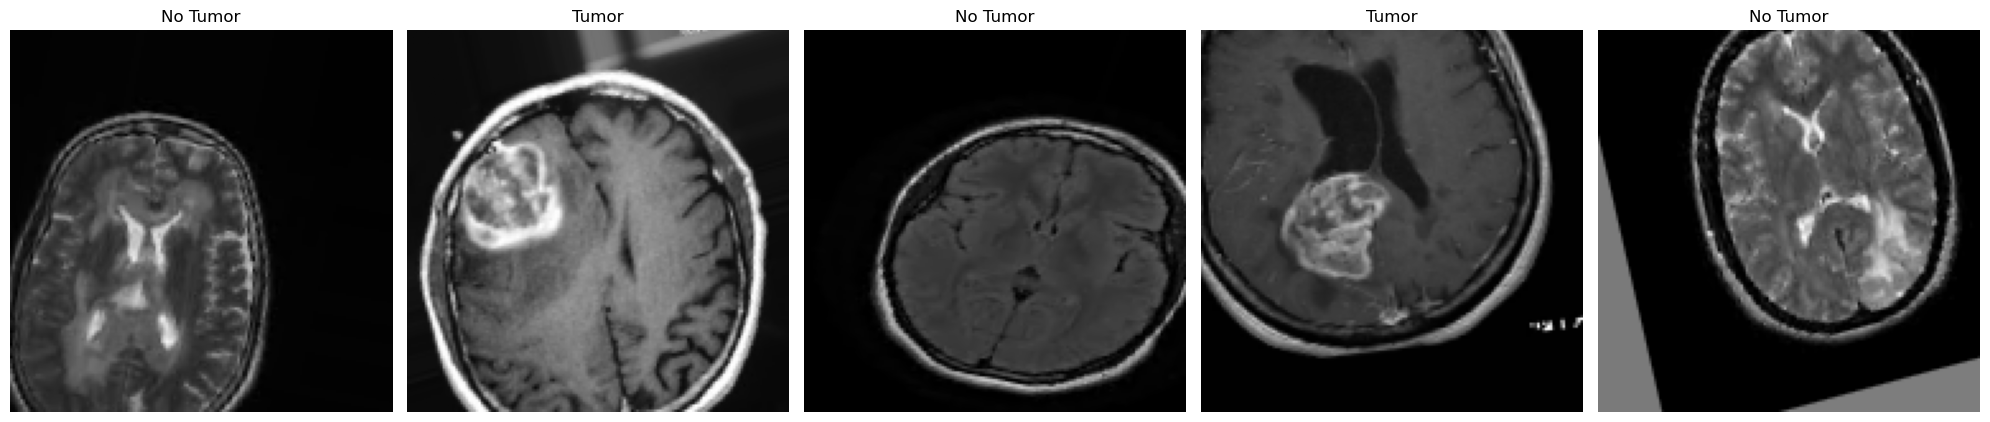

In [3]:
import matplotlib.pyplot as plt  # Import the matplotlib library for plotting and visualizing images

# Function to plot a batch of images along with their labels
def plot_images(images_arr, labels):
    # Create a figure with a number of subplots equal to the number of images
    fig, axes = plt.subplots(1, len(images_arr), figsize=(20, 20))  # Create a figure with one row and multiple columns
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Loop through the images, axes, and labels to display them
    for img, ax, label in zip(images_arr, axes, labels):
        ax.imshow(img)  # Display the image on the current subplot
        ax.set_title(f"{'Tumor' if label == 1 else 'No Tumor'}")  # Set the title based on the label (1 = Tumor, 0 = No Tumor)
        ax.axis('off')  # Hide the axis for better visualization of the image

    plt.tight_layout()  # Adjust the layout to prevent overlapping elements
    plt.show()  # Display the images and their labels

# Get a batch of images and labels from the augmented training data
images, labels = next(train_data)  # Get one batch of data from the training generator

# Visualize the first 5 images from the batch
plot_images(images[:5], labels[:5])  # Call the plot_images function to display the first 5 images and their labels



### Imptrotng the VGG16 in order to train our model 

In [4]:
# Load the VGG16 model without the top layers (fully connected layers)
# We use the weights pre-trained on ImageNet, and exclude the fully connected layers because we'll add our own
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers so their weights will not be updated during training
for layer in vgg_base.layers:
    layer.trainable = False

# Add custom layers on top of the VGG16 base model to adapt it to the specific task (binary classification)
x = vgg_base.output  # Get the output of the last layer of VGG16
x = Flatten()(x)  # Flatten the output to create a one-dimensional vector for the dense layers
x = Dense(128, activation='relu')(x)  # Add a fully connected layer with 128 neurons and ReLU activation
x = Dropout(0.5)(x)  # Add dropout with a rate of 50% to reduce overfitting
x = Dense(1, activation='sigmoid')(x)  # Add a final dense layer with 1 neuron and sigmoid activation for binary classification (tumor or no tumor)

# Create the final model by combining the VGG16 base and the custom layers
model = Model(inputs=vgg_base.input, outputs=x)

# Compile the model
# Use Adam optimizer, binary cross-entropy loss for binary classification, and accuracy as a performance metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_data,  # Training data generator
    validation_data=validation_data,  # Validation data generator
    epochs=10  # Train for 10 epochs (can be adjusted based on performance)
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4975 - loss: 0.8823 - val_accuracy: 0.7400 - val_loss: 0.4642
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6677 - loss: 0.7205 - val_accuracy: 0.8000 - val_loss: 0.4341
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.6465 - loss: 0.6685 - val_accuracy: 0.7400 - val_loss: 0.4480
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6889 - loss: 0.5628 - val_accuracy: 0.8000 - val_loss: 0.3909
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7887 - loss: 0.4801 - val_accuracy: 0.8000 - val_loss: 0.3461
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.7718 - loss: 0.4755 - val_accuracy: 0.8400 - val_loss: 0.3491
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7715 - loss: 0.4867 - val_accuracy: 0.8200 - val_loss: 0.3456
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.7419 - loss: 0.5319 - val_accuracy: 0.8800 - val_loss: 0.3421
Epoch 9/

### Showing the accuracy and loss plot

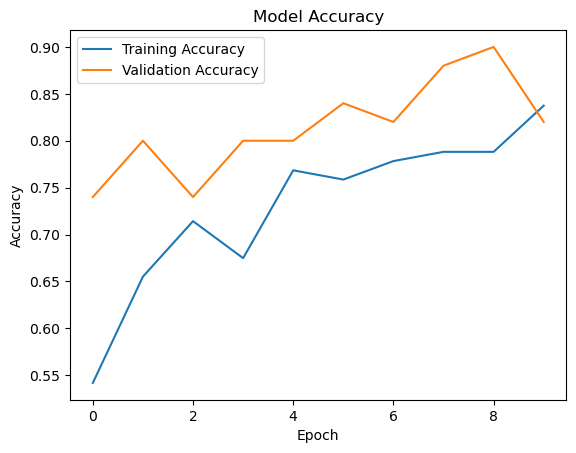

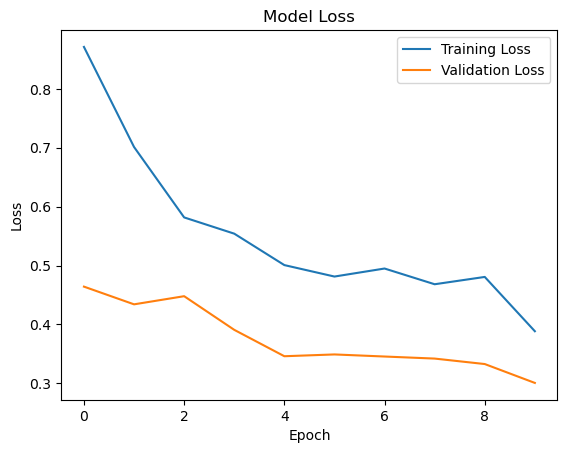

In [5]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.title('Model Accuracy')  # Set the title for the accuracy plot
plt.ylabel('Accuracy')  # Label the y-axis as "Accuracy"
plt.xlabel('Epoch')  # Label the x-axis as "Epoch"
plt.legend()  # Display the legend to differentiate between training and validation accuracy
plt.show()  # Display the accuracy plot

# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.title('Model Loss')  # Set the title for the loss plot
plt.ylabel('Loss')  # Label the y-axis as "Loss"
plt.xlabel('Epoch')  # Label the x-axis as "Epoch"
plt.legend()  # Display the legend to differentiate between training and validation loss
plt.show()  # Display the loss plot
